In [109]:
import numpy as np
from scipy.integrate import odeint
import sympy as sp
from sympy import latex
import matplotlib.pyplot as plt
from IPython.display import display

# 定义符号变量
x, y = sp.symbols('x,y')
ε,Ri,Va,Cei,A,Rp,Vε,E,Cep,s,Cs = sp.symbols('ε R_i V_a C_ei a R_p V_ε E C_ep s C_s')
# V, C, B, F, P1, P0 = sp.symbols('V C B F P1 P0')

# # # 定义参数值（可以根据需要调整）
params = {ε:1.1,Ri:5,Va:2,Cei:3,A:1.1,Rp:5,Vε:2,E:1,Cep:3,s:0.9,Cs:1}

# 收益矩阵
profit_mat=[[ε*Ri + Va - Cei,A*Rp + Vε + E - Cep],
            [(1 - s)*Ri + Va - Cei, A*Rp - Cs],
            [ε*Ri,Rp + Vε + E - Cep],
            [Ri,Rp]]

# profit_mat=[
#     [V - C - B,P1 + B ],
#     [F - C,P0 - F],
#     [V ,P1],
#     [0,P0]
# ]

### 1. 复制动态方程构建
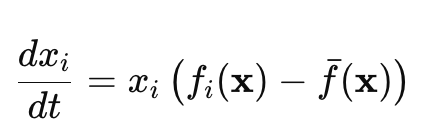

In [110]:

# 1. 复制动态方程构建
# 企业1参与策略的平均收益
avg_U_firm_participate = y * profit_mat[0][0] + (1 - y) * profit_mat[1][0]
avg_U_firm_not_participate = y * profit_mat[2][0]  + (1 - y) * profit_mat[3][0]
phi_x = x * (avg_U_firm_participate- (x * avg_U_firm_participate + (1 - x) * avg_U_firm_not_participate))

# 企业2监督策略的平均收益
avg_U_gov_supervise = x * profit_mat[0][1] + (1 - x) * profit_mat[2][1]
avg_U_gov_no_supervise = x * profit_mat[1][1]  + (1 - x) * profit_mat[3][1]
phi_y = y * (avg_U_gov_supervise - (y * avg_U_gov_supervise + (1 - y) * avg_U_gov_no_supervise))

print('企业1的复制动态方程：',sp.factor(phi_x))
print("企业2的复制动态方程：",sp.factor(phi_y))
display(sp.factor(phi_x))
display(sp.factor(phi_y))



企业1的复制动态方程： -x*(x - 1)*(-C_ei + R_i*s*y - R_i*s + V_a)
企业2的复制动态方程： -y*(y - 1)*(-C_ep + C_s*x + E + V_ε)


-x*(x - 1)*(-C_ei + R_i*s*y - R_i*s + V_a)

-y*(y - 1)*(-C_ep + C_s*x + E + V_ε)

### 2. 求解均衡点

通过分析复制动态方程的固定点（即策略频率不再变化的点），可以确定ESS。在该博弈场景下，我们需要解出$$dx/dt=0$$ 和 $$dy/dt=0$$ 的解，从而找到平衡点。



In [111]:
# 2. 求解均衡点
equilibrium_points = sp.solve([phi_x,phi_y], [x,y])  
# equilibrium_y = sp.solve(phi_y, [x,y])
# print("企业1的复制动态方程：",sp.factor(equilibrium_x))
# print("企业1的复制动态方程：",sp.factor(equilibrium_y))

# 筛选出 [x, y] 均衡点对
# equilibrium_points = [(x_val, y_val)  for x_val in equilibrium_x for y_val in equilibrium_y]

print('均衡点:')
for point in equilibrium_points:
    print(f'x: {point[0]}, y: {point[1]}')
    # display('x: 'point[0], 'y: ',point[1])


# TODO:这里可能加一个过滤条件会更好一点，因为有些均衡点是不合理的

均衡点:
x: 0, y: 0
x: 0, y: 1
x: 1, y: 0
x: 1, y: 1
x: (C_ep - E - V_ε)/C_s, y: (C_ei + R_i*s - V_a)/(R_i*s)


### 3. 稳定性分析 - 计算雅可比矩阵并求特征值

#### 3.1 形式化与稳定性定义
我们希望均衡点是稳定的，即当系统处于固定点附近时，是否会回到该点（稳定）或远离该点（不稳定）。


已知$x=x(t)$，$y=y(t)$，$\mathbf{z}=[x,y]^T$，固定点 $\mathbf{z}^*$ 附近，可以将 $\mathbf{z}(t)$ 表示为 $\mathbf{z} = \mathbf{z}^* + \delta \mathbf{z}$，其中 $\delta \mathbf{z}$ 是一个小的偏移量。

稳定性假定为：当$t \to \infty$时 ,$\mathbf{z}=\mathbf{z}^*$，则此时$\mathbf{z}*$是稳定的。

#### 3.2 求解$\mathbf{z}(t)的表达式$

将 $\mathbf{z}$ 代入系统方程，得到：

$$
\frac{d(\mathbf{z}^* + \delta \mathbf{z})}{dt} = \mathbf{F}(\mathbf{z}^* + \delta \mathbf{z}).
$$

在$\mathbf{z}$处泰勒展开，我们可以将 $\mathbf{F}(\mathbf{z}^* + \delta \mathbf{z})$ 近似为：

$$
\mathbf{F}(\mathbf{z}^* + \delta \mathbf{z}) = \mathbf{F}(\mathbf{z}^*)+ \mathbf{J}(\mathbf{z}^*) \cdot \delta \mathbf{z}+o((\delta \mathbf{z})^2).
$$

由于 $\mathbf{z}^*$ 是固定点，有 $\mathbf{F}(\mathbf{z}^*) = 0$，因此，系统在固定点附近的动态行为可以通过以下线性化方程来描述：

$$
\frac{d \delta \mathbf{z}}{dt} = \mathbf{J}(\mathbf{z}^*) \cdot \delta \mathbf{z}.
$$

通过求解该方程，解的形式为：

$$
\delta \mathbf{z}(t) = \sum_{i=1}^n c_i e^{\lambda_i t} \mathbf{v}_i,
$$

其中，$\lambda_i$ 是雅可比矩阵 $\mathbf{J}$ 的第 $i$ 个特征值，$\mathbf{v}_i$ 是对应的特征向量，$c_i$ 是与初始条件相关的常数。

此时则有

$$
\mathbf{z}=\mathbf{z}^* + \delta \mathbf{z}=\mathbf{z}^* + \sum_{i=1}^n c_i e^{\lambda_i t} \mathbf{v}_i
$$

若要当$t \to \infty$时 ,$\mathbf{z}=\mathbf{z}^*$，则需要当$t \to \infty$时，$\delta \mathbf{z}(t)=0$


#### 3.3 重要结论

1. 如果特征值的实部 $\operatorname{Re}(\lambda_i) < 0$，则 $e^{\lambda_i t} \to 0$ 随时间趋于零，意味当$t \to \infty$时 ,$\mathbf{z}=\mathbf{z}^*$,固定点为**稳定点**（吸引子）。

2. 如果特征值的实部 $\operatorname{Re}(\lambda_i) > 0$，则 $e^{\lambda_i t} \to \infty$ 随时间增加，意味着当$t \to \infty$时 ,$\mathbf{z} \ne \mathbf{z}^*$，导致固定点**不稳定**。

3. 如果某个特征值的实部为零，系统的稳定性无法直接判断。此时可能需要进一步的非线性分析（如中心流形理论）来确定系统的长时间行为。

In [112]:

# 3. 稳定性分析 - 计算雅可比矩阵并求特征值
# 定义复制动态方程的向量
phi = sp.Matrix([phi_x, phi_y])
variables = sp.Matrix([x, y])

# 计算雅可比矩阵
J = phi.jacobian(variables)
display(J)

# 检查每个均衡点的稳定性
for point in equilibrium_points:
    J_at_point = J.subs([(x, point[0]), (y, point[1])])
    eigenvalues = J_at_point.eigenvals()

    print(f'\n均衡点 x: {point[0]}, y: {point[1]} 的雅可比矩阵特征值:')
    for eig in eigenvalues:
        # display(f'\\text{{特征值:}} {eig}, 实部: {sp.re(eig)}')
        display('特征值:',eig, '实部:' ,sp.re(eig))
        # if sp.re(eig) > 0:
        #     print('此均衡点是不稳定的')

        # else:
        #     print('此均衡点是稳定的')
        


Matrix([
[-x*(y*(-C_ei + R_i*ε + V_a) + (1 - y)*(-C_ei + R_i*(1 - s) + V_a)) + x*(R_i*y*ε + R_i*(1 - y) - y*(-C_ei + R_i*ε + V_a) - (1 - y)*(-C_ei + R_i*(1 - s) + V_a)) + y*(-C_ei + R_i*ε + V_a) - (1 - x)*(R_i*y*ε + R_i*(1 - y)) + (1 - y)*(-C_ei + R_i*(1 - s) + V_a),                                                                                                                                                                                                         x*(R_i*ε - R_i*(1 - s) - x*(R_i*ε - R_i*(1 - s)) - (1 - x)*(R_i*ε - R_i))],
[                                                                                                                                                                                                y*(R_p*a - R_p - y*(R_p*a - R_p) - (1 - y)*(-C_s + R_p*a - R_p)), x*(-C_ep + E + R_p*a + V_ε) - y*(x*(-C_ep + E + R_p*a + V_ε) + (1 - x)*(-C_ep + E + R_p + V_ε)) + y*(R_p*(1 - x) + x*(-C_s + R_p*a) - x*(-C_ep + E + R_p*a + V_ε) - (1 - x)*(-C_ep + E + R_p + V_ε)) 


均衡点 x: 0, y: 0 的雅可比矩阵特征值:


'特征值:'

-C_ei - R_i*s + V_a

'实部:'

-re(C_ei) + re(V_a) - re(R_i*s)

'特征值:'

-C_ep + E + V_ε

'实部:'

-re(C_ep) + re(E) + re(V_ε)


均衡点 x: 0, y: 1 的雅可比矩阵特征值:


'特征值:'

-C_ei + V_a

'实部:'

-re(C_ei) + re(V_a)

'特征值:'

C_ep - E - V_ε

'实部:'

re(C_ep) - re(E) - re(V_ε)


均衡点 x: 1, y: 0 的雅可比矩阵特征值:


'特征值:'

C_ei + R_i*s - V_a

'实部:'

re(C_ei) - re(V_a) + re(R_i*s)

'特征值:'

-C_ep + C_s + E + V_ε

'实部:'

-re(C_ep) + re(C_s) + re(E) + re(V_ε)


均衡点 x: 1, y: 1 的雅可比矩阵特征值:


'特征值:'

C_ei - V_a

'实部:'

re(C_ei) - re(V_a)

'特征值:'

C_ep - C_s - E - V_ε

'实部:'

re(C_ep) - re(C_s) - re(E) - re(V_ε)


均衡点 x: (C_ep - E - V_ε)/C_s, y: (C_ei + R_i*s - V_a)/(R_i*s) 的雅可比矩阵特征值:


'特征值:'

-sqrt((C_ei - V_a)*(C_ei + R_i*s - V_a)*(C_ep - E - V_ε)*(C_ep - C_s - E - V_ε)/(C_s*R_i*s))

'实部:'

-(((re(C_ei**2*C_ep**2) + re(C_ei**2*E**2) + re(C_ei**2*V_ε**2) + re(C_ep**2*V_a**2) + re(E**2*V_a**2) + re(V_a**2*V_ε**2) - 2*re(C_ei*C_ep**2*V_a) - 2*re(C_ei*E**2*V_a) - 2*re(C_ei*V_a*V_ε**2) - re(C_ei**2*C_ep*C_s) - 2*re(C_ei**2*C_ep*E) - 2*re(C_ei**2*C_ep*V_ε) + re(C_ei**2*C_s*E) + re(C_ei**2*C_s*V_ε) + 2*re(C_ei**2*E*V_ε) - re(C_ep*C_s*V_a**2) - 2*re(C_ep*E*V_a**2) - 2*re(C_ep*V_a**2*V_ε) + re(C_s*E*V_a**2) + re(C_s*V_a**2*V_ε) + 2*re(E*V_a**2*V_ε) + 2*re(C_ei*C_ep*C_s*V_a) + 4*re(C_ei*C_ep*E*V_a) + 4*re(C_ei*C_ep*V_a*V_ε) + re(C_ei*C_ep**2*R_i*s) - 2*re(C_ei*C_s*E*V_a) - 2*re(C_ei*C_s*V_a*V_ε) - 4*re(C_ei*E*V_a*V_ε) + re(C_ei*E**2*R_i*s) + re(C_ei*R_i*V_ε**2*s) - re(C_ep**2*R_i*V_a*s) - re(E**2*R_i*V_a*s) - re(R_i*V_a*V_ε**2*s) - re(C_ei*C_ep*C_s*R_i*s) - 2*re(C_ei*C_ep*E*R_i*s) - 2*re(C_ei*C_ep*R_i*V_ε*s) + re(C_ei*C_s*E*R_i*s) + re(C_ei*C_s*R_i*V_ε*s) + 2*re(C_ei*E*R_i*V_ε*s) + re(C_ep*C_s*R_i*V_a*s) + 2*re(C_ep*E*R_i*V_a*s) + 2*re(C_ep*R_i*V_a*V_ε*s) - re(C_s*E*R_i*V_a*s) - re

'特征值:'

sqrt((C_ei - V_a)*(C_ei + R_i*s - V_a)*(C_ep - E - V_ε)*(C_ep - C_s - E - V_ε)/(C_s*R_i*s))

'实部:'

(((re(C_ei**2*C_ep**2) + re(C_ei**2*E**2) + re(C_ei**2*V_ε**2) + re(C_ep**2*V_a**2) + re(E**2*V_a**2) + re(V_a**2*V_ε**2) - 2*re(C_ei*C_ep**2*V_a) - 2*re(C_ei*E**2*V_a) - 2*re(C_ei*V_a*V_ε**2) - re(C_ei**2*C_ep*C_s) - 2*re(C_ei**2*C_ep*E) - 2*re(C_ei**2*C_ep*V_ε) + re(C_ei**2*C_s*E) + re(C_ei**2*C_s*V_ε) + 2*re(C_ei**2*E*V_ε) - re(C_ep*C_s*V_a**2) - 2*re(C_ep*E*V_a**2) - 2*re(C_ep*V_a**2*V_ε) + re(C_s*E*V_a**2) + re(C_s*V_a**2*V_ε) + 2*re(E*V_a**2*V_ε) + 2*re(C_ei*C_ep*C_s*V_a) + 4*re(C_ei*C_ep*E*V_a) + 4*re(C_ei*C_ep*V_a*V_ε) + re(C_ei*C_ep**2*R_i*s) - 2*re(C_ei*C_s*E*V_a) - 2*re(C_ei*C_s*V_a*V_ε) - 4*re(C_ei*E*V_a*V_ε) + re(C_ei*E**2*R_i*s) + re(C_ei*R_i*V_ε**2*s) - re(C_ep**2*R_i*V_a*s) - re(E**2*R_i*V_a*s) - re(R_i*V_a*V_ε**2*s) - re(C_ei*C_ep*C_s*R_i*s) - 2*re(C_ei*C_ep*E*R_i*s) - 2*re(C_ei*C_ep*R_i*V_ε*s) + re(C_ei*C_s*E*R_i*s) + re(C_ei*C_s*R_i*V_ε*s) + 2*re(C_ei*E*R_i*V_ε*s) + re(C_ep*C_s*R_i*V_a*s) + 2*re(C_ep*E*R_i*V_a*s) + 2*re(C_ep*R_i*V_a*V_ε*s) - re(C_s*E*R_i*V_a*s) - re(

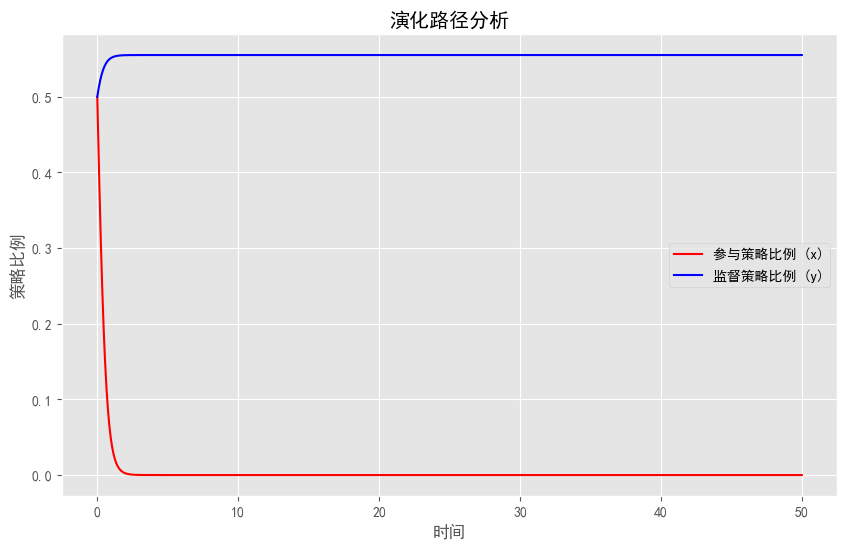

In [113]:

# 4. 演化路径分析
# 转换复制动态方程为数值函数
# phi_x_func = sp.lambdify((x, V, C, B, F, P1, P0), phi_x.subs(params), 'numpy')
# phi_y_func = sp.lambdify((y, V, C, B, F, P1, P0), phi_y.subs(params), 'numpy')

# params[ε]=0
phi_x_func = sp.lambdify((x,y,ε,Ri,Va,Cei,A,Rp,Vε,E,Cep,s,Cs), phi_x.subs(params), 'numpy')
phi_y_func = sp.lambdify((x,y,ε,Ri,Va,Cei,A,Rp,Vε,E,Cep,s,Cs), phi_y.subs(params), 'numpy')

# 定义微分方程组
def replicator_dynamics(X, t, params):
    x, y = X
    dxdt = phi_x_func(x,y, *params.values())
    dydt = phi_y_func(x,y, *params.values())
    return [dxdt, dydt]

# 设置初始条件和时间范围
initial_conditions = [0.5, 0.5]  # 初始参与策略比例
time_span = np.linspace(0, 50, 1000)  # 时间范围

# 求解微分方程
solution = odeint(replicator_dynamics, initial_conditions, time_span, args=(params,))

# 绘制演化路径
plt.rcParams['font.sans-serif'] = ['SimHei']  # 指定默认字体
plt.rcParams['axes.unicode_minus'] = False	
plt.style.use('ggplot')
plt.figure(figsize=(10, 6))
plt.plot(time_span, solution[:, 0], label='参与策略比例 (x)', color='r')
plt.plot(time_span, solution[:, 1], label='监督策略比例 (y)', color='b')
plt.xlabel('时间')
plt.ylabel('策略比例')
plt.title('演化路径分析')
plt.legend()
plt.grid(True)
plt.show()


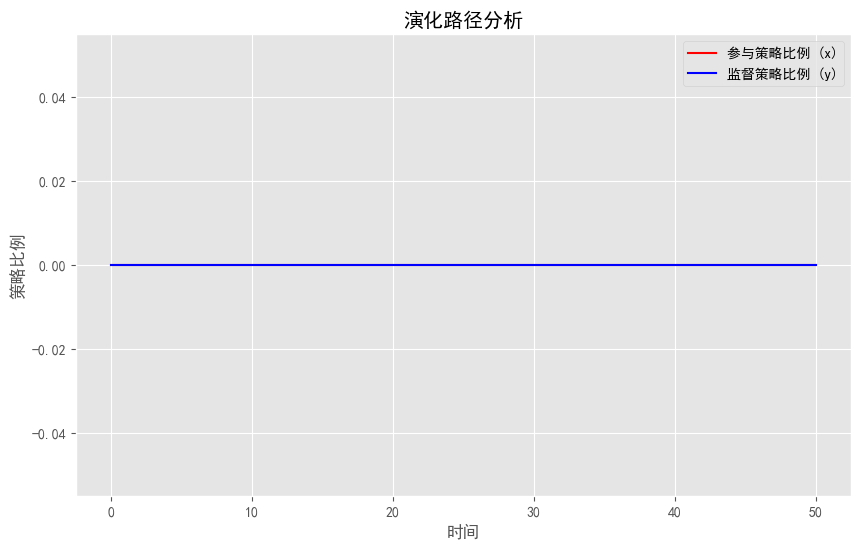

In [114]:
# 设置初始条件和时间范围
initial_conditions = [0, 0]  # 初始参与策略比例
time_span = np.linspace(0, 50, 1000)  # 时间范围

# 求解微分方程
solution = odeint(replicator_dynamics, initial_conditions, time_span, args=(params,))

# 绘制演化路径
plt.rcParams['font.sans-serif'] = ['SimHei']  # 指定默认字体
plt.rcParams['axes.unicode_minus'] = False	
plt.style.use('ggplot')
plt.figure(figsize=(10, 6))
plt.plot(time_span, solution[:, 0], label='参与策略比例 (x)', color='r')
plt.plot(time_span, solution[:, 1], label='监督策略比例 (y)', color='b')
plt.xlabel('时间')
plt.ylabel('策略比例')
plt.title('演化路径分析')
plt.legend()
plt.grid(True)
plt.show()

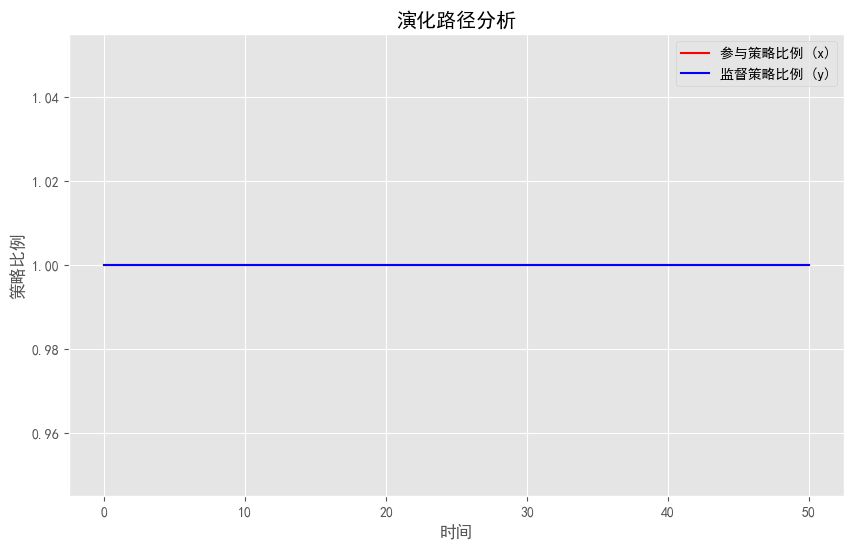

In [115]:
# 设置初始条件和时间范围
initial_conditions = [1, 1]  # 初始参与策略比例
time_span = np.linspace(0, 50, 1000)  # 时间范围

# 求解微分方程
solution = odeint(replicator_dynamics, initial_conditions, time_span, args=(params,))

# 绘制演化路径
plt.rcParams['font.sans-serif'] = ['SimHei']  # 指定默认字体
plt.rcParams['axes.unicode_minus'] = False	
plt.style.use('ggplot')
plt.figure(figsize=(10, 6))
plt.plot(time_span, solution[:, 0], label='参与策略比例 (x)', color='r')
plt.plot(time_span, solution[:, 1], label='监督策略比例 (y)', color='b')
plt.xlabel('时间')
plt.ylabel('策略比例')
plt.title('演化路径分析')
plt.legend()
plt.grid(True)
plt.show()

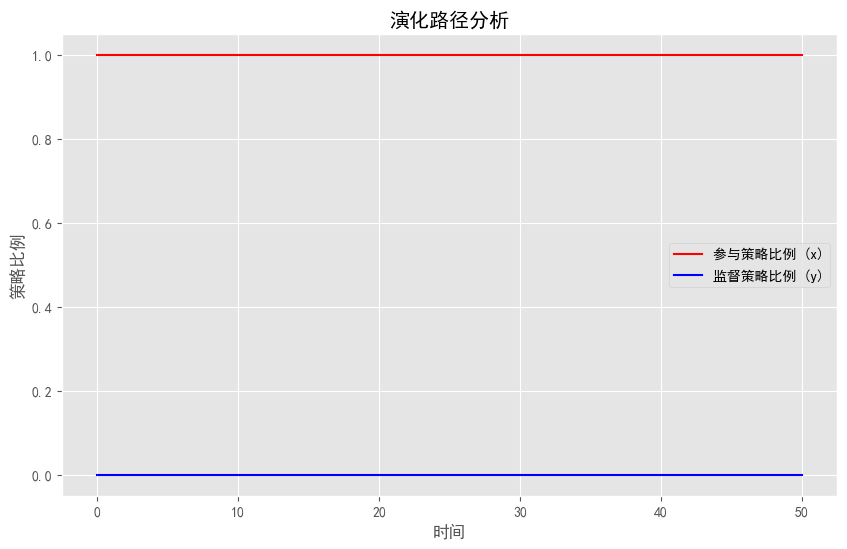

In [116]:
# 设置初始条件和时间范围
initial_conditions = [1, 0]  # 初始参与策略比例
time_span = np.linspace(0, 50, 1000)  # 时间范围

# 求解微分方程
solution = odeint(replicator_dynamics, initial_conditions, time_span, args=(params,))

# 绘制演化路径
plt.rcParams['font.sans-serif'] = ['SimHei']  # 指定默认字体
plt.rcParams['axes.unicode_minus'] = False	
plt.style.use('ggplot')
plt.figure(figsize=(10, 6))
plt.plot(time_span, solution[:, 0], label='参与策略比例 (x)', color='r')
plt.plot(time_span, solution[:, 1], label='监督策略比例 (y)', color='b')
plt.xlabel('时间')
plt.ylabel('策略比例')
plt.title('演化路径分析')
plt.legend()
plt.grid(True)
plt.show()

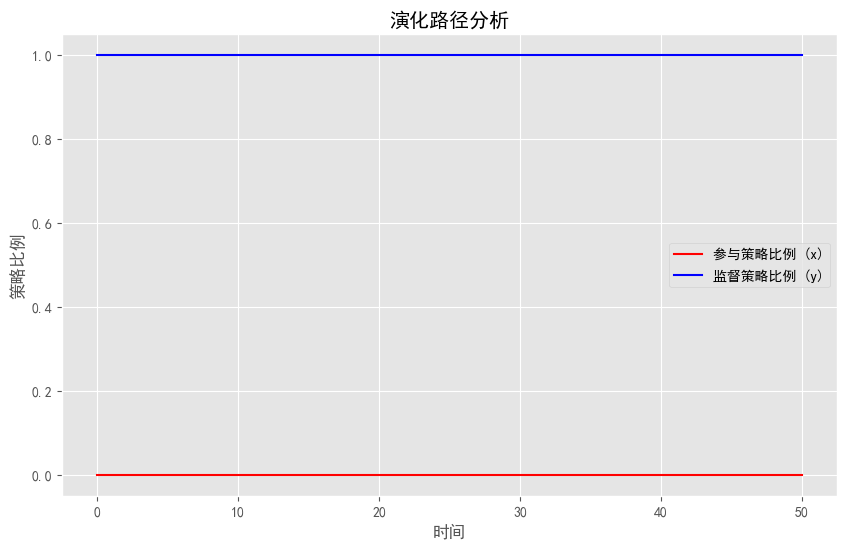

In [117]:
# 设置初始条件和时间范围
initial_conditions = [0, 1]  # 初始参与策略比例
time_span = np.linspace(0, 50, 1000)  # 时间范围

# 求解微分方程
solution = odeint(replicator_dynamics, initial_conditions, time_span, args=(params,))

# 绘制演化路径
plt.rcParams['font.sans-serif'] = ['SimHei']  # 指定默认字体
plt.rcParams['axes.unicode_minus'] = False	
plt.style.use('ggplot')
plt.figure(figsize=(10, 6))
plt.plot(time_span, solution[:, 0], label='参与策略比例 (x)', color='r')
plt.plot(time_span, solution[:, 1], label='监督策略比例 (y)', color='b')
plt.xlabel('时间')
plt.ylabel('策略比例')
plt.title('演化路径分析')
plt.legend()
plt.grid(True)
plt.show()